In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

# some adjustments
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

#from google.colab import files
#uploaded = files.upload()


df_ = pd.read_csv('data/diabetes.csv')
df = df_.copy()

# auxiliary functions
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def grab_col_names(dataframe, cat_th=10, car_th=20):
    """


    ------
        dataframe: dataframe

        cat_th: int, optional

        car_th: int, optinal


    Returns
    ------
        cat_cols: list
                Categorical features
        num_cols: list
                Numerical features
        cat_but_car: list
               Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

df.columns = [col.upper() for col in df.columns]
cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [2]:
df.isnull().sum()
#df=df.drop(["STDS: TIME SINCE LAST DIAGNOSIS", "STDS: TIME SINCE FIRST DIAGNOSIS", "HINSELMANN", "SCHILLER", "CITOLOGY"], axis=1)
df[["GLUCOSE","BLOODPRESSURE","SKINTHICKNESS","INSULIN","BMI"]]= df[["GLUCOSE","BLOODPRESSURE","SKINTHICKNESS","INSULIN","BMI"]].replace(0,np.nan)
na_cols = missing_values_table(df, True)

#df.rename(columns={"BIOPSY": "OUTCOME"}, inplace=True)
#df = df.reindex(sorted(df.columns), axis=1)
df.head()



               n_miss  ratio
INSULIN           374 48.700
SKINTHICKNESS     227 29.560
BLOODPRESSURE      35  4.560
BMI                11  1.430
GLUCOSE             5  0.650


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6,148.000,72.000,35.000,NaN,33.600,0.627,50,1
1,1,85.000,66.000,29.000,NaN,26.600,0.351,31,0
2,8,183.000,64.000,NaN,NaN,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1


In [3]:
def median_target(variable):
    temp = df[df[variable].notnull()]
    temp = temp[[variable, 'OUTCOME']].groupby(['OUTCOME'])[[variable]].median().reset_index()
    return temp

In [4]:
columns = df.columns
columns = columns.drop("OUTCOME")

for col in columns:
    df.loc[(df['OUTCOME'] == 0) & (df[col].isnull()), col] = median_target(col)[col][0]
    df.loc[(df['OUTCOME'] == 1) & (df[col].isnull()), col] = median_target(col)[col][1]

In [5]:
df = pd.get_dummies(df[cat_cols + num_cols], drop_first=True)

accuracy:  0.7748917748917749
f1-score: 0.6338028169014085


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


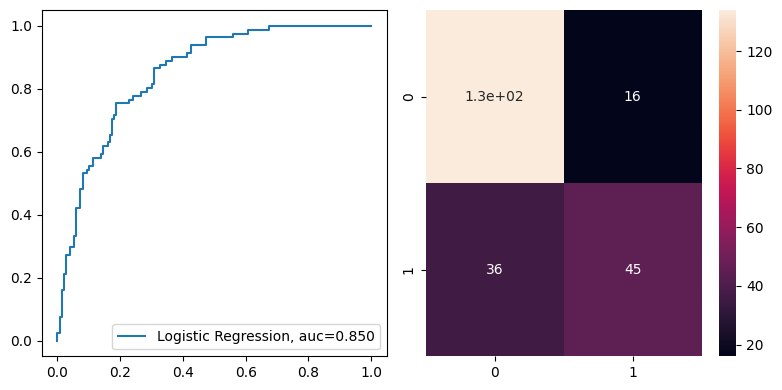

In [6]:
from sklearn.linear_model import LogisticRegression

y = df["OUTCOME"]
X=df.drop(["OUTCOME"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

#Model 1
lr_model=LogisticRegression().fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print("accuracy: ", accuracy_score(y_pred, y_test))

from sklearn.metrics import f1_score
print("f1-score:", f1_score(y_test,y_pred))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = lr_model.predict_proba(X_test)
y_pred_proba = probs[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
axes[0].plot(fpr,tpr,label="Logistic Regression, auc="+str(auc)[:5])
axes[0].legend(loc=4)


from sklearn.metrics import confusion_matrix
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, ax=axes[1])
fig.tight_layout()
plt.show()


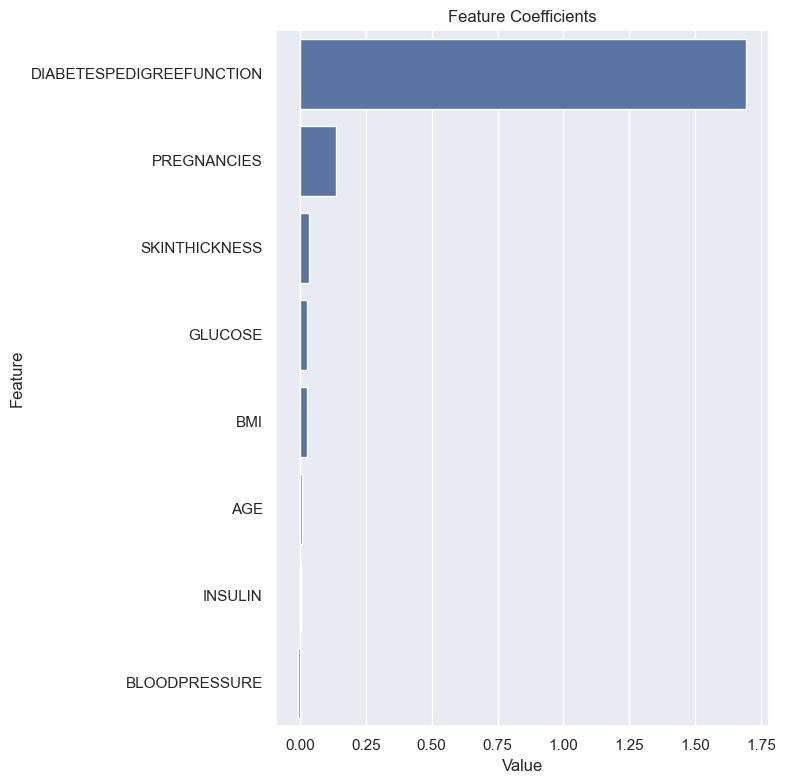

In [7]:
def plot_importance(model, feature_names, num=None):
    if num is None:
        num = len(feature_names)
    feature_imp = pd.DataFrame({'Value': model.coef_[0], 'Feature': feature_names})
    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1)
    sns.barplot(
        x="Value",
        y="Feature",
        data=feature_imp.sort_values(by="Value", ascending=False).head(num)
    )
    plt.title('Feature Coefficients')
    plt.tight_layout()
    plt.show()

plot_importance(lr_model, X.columns)

In [8]:
rs = StandardScaler()
X_std=X.copy()
X_std[num_cols] = rs.fit_transform(X_std[num_cols])
X_std.head()

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.30, random_state=17)

#Linear Model
lr_model=LogisticRegression().fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print("accuracy: ", accuracy_score(y_pred, y_test))

from sklearn.metrics import f1_score
print("f1-score:", f1_score(y_test,y_pred))

accuracy:  0.7792207792207793
f1-score: 0.6433566433566433


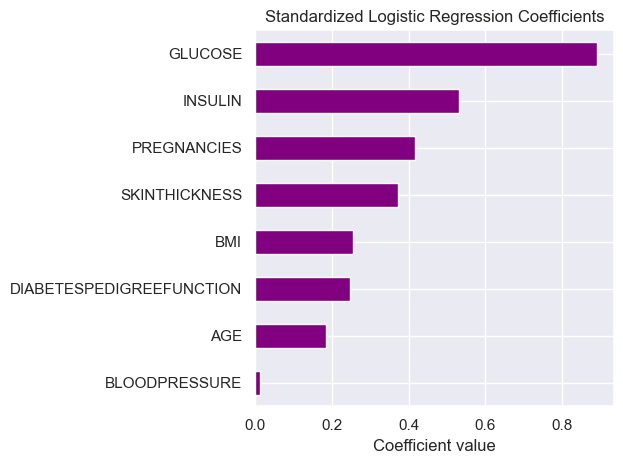

In [9]:
# Plot standardized logistic-regression coefficients
linear_importances = pd.Series(lr_model.coef_[0], index=X_train.columns).sort_values(ascending=True)
fig, ax = plt.subplots()
linear_importances.plot.barh(ax=ax, color='purple')
ax.set_title("Standardized Logistic Regression Coefficients")
ax.set_xlabel("Coefficient value")
fig.tight_layout()
plt.show()

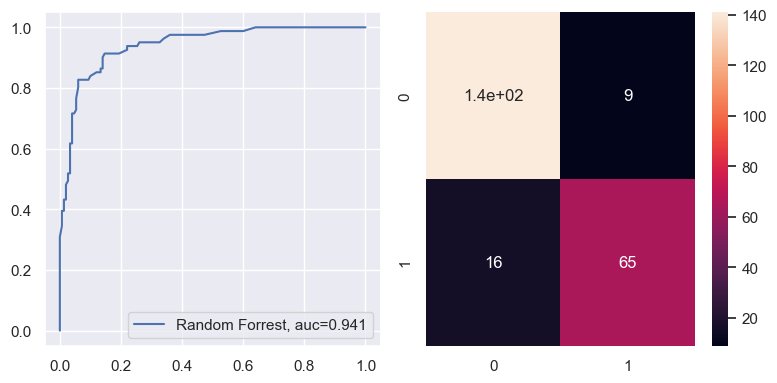

In [10]:



import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier().fit(X_train, y_train)


y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = rf_model.predict_proba(X_test)
y_pred_proba = probs[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
axes[0].plot(fpr,tpr,label="Random Forrest, auc="+str(auc)[:5])
axes[0].legend(loc=4)
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, ax=axes[1])
fig.tight_layout()
plt.show()


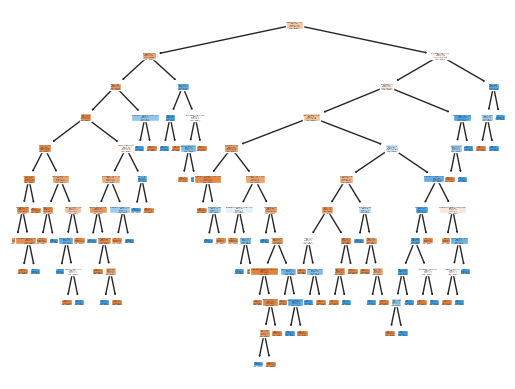

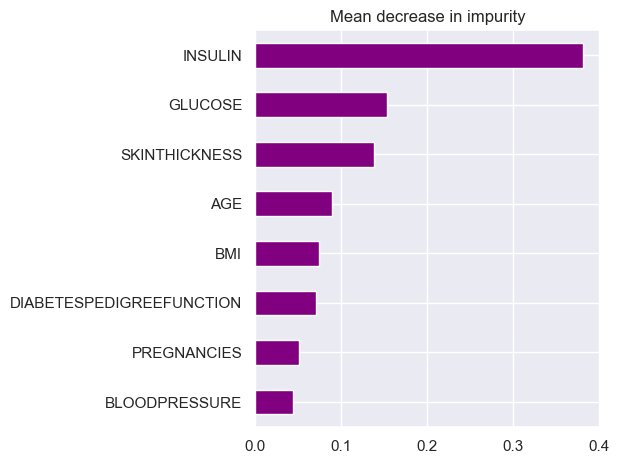

In [11]:
from sklearn import tree

# Visualize one decision tree from the random forest
_ = tree.plot_tree(
    rf_model.estimators_[5],
    feature_names=X_train.columns,
    class_names=["Diabetes", "Normal"],
    filled=True,
)

feature_names = X_train.columns
importances = rf_model.feature_importances_

# Plot MDI feature importance
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)
fig, ax = plt.subplots()
forest_importances.plot.barh(ax=ax, color='purple')
ax.set_title("Mean decrease in impurity")
fig.tight_layout()
plt.show()

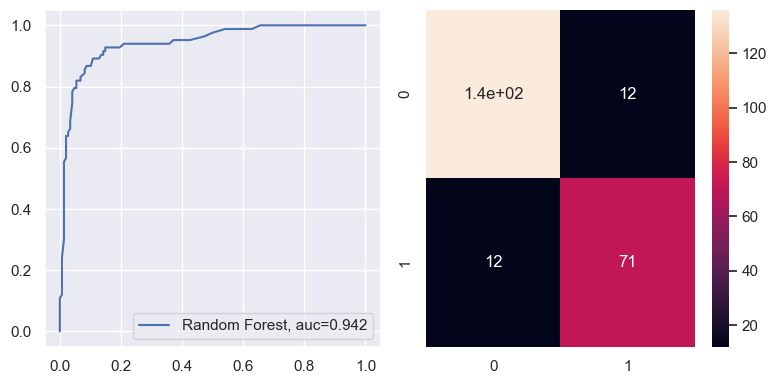

In [12]:
# Create a copy of the feature matrix and add random control features
X_modified = X.copy()
rng = np.random.RandomState(42)
X_modified["RANDOM_NUM"] = rng.normal(size=X.shape[0])
X_modified["RANDOM_CAT"] = rng.randint(3, size=X.shape[0])

# Split and fit a classifier
X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(
    X_modified, y, test_size=0.30, random_state=23
)
rf_model_rand = RandomForestClassifier(random_state=23).fit(X_train_rand, y_train_rand)

y_pred_rand = rf_model_rand.predict(X_test_rand)
accuracy_score(y_test_rand, y_pred_rand)

# Plot ROC + confusion matrix
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
import sklearn.metrics as metrics
probs = rf_model_rand.predict_proba(X_test_rand)
y_pred_proba = probs[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test_rand, y_pred_proba)
auc = metrics.roc_auc_score(y_test_rand, y_pred_proba)
axes[0].plot(fpr, tpr, label="Random Forest, auc=" + str(auc)[:5])
axes[0].legend(loc=4)
cf_matrix = confusion_matrix(y_test_rand, y_pred_rand)
sns.heatmap(cf_matrix, annot=True, ax=axes[1])
fig.tight_layout()
plt.show()

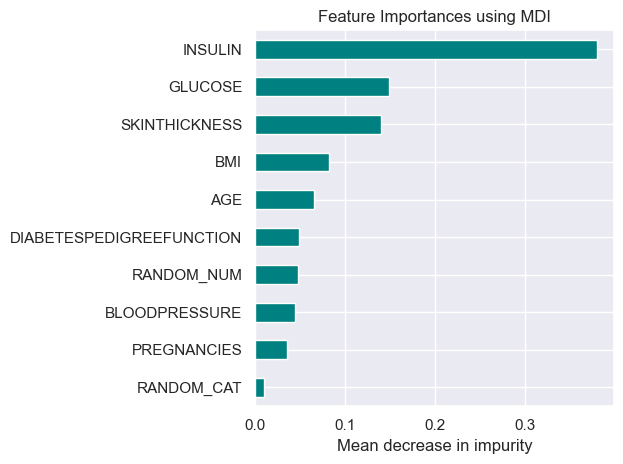

In [13]:
feature_names = X_train_rand.columns
mdi_importances = pd.Series(
    rf_model_rand.feature_importances_, index=feature_names
).sort_values(ascending=True)

fig, ax = plt.subplots()
mdi_importances.plot.barh(ax=ax, color="teal")
ax.set_title("Feature Importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [14]:


# Split the set again and fit the model (to remove the previous random features)
#X=X.drop(["RANDOM_CAT", "RANDOM_NUM"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=14)
rf_model = RandomForestClassifier().fit(X_train, y_train)


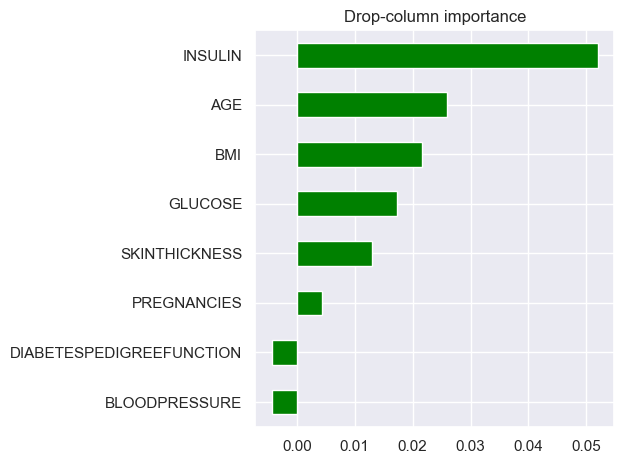

In [15]:
def drop_features(features, X_train, y_train, X_test, y_test, model=None):
    if model is None:
        model = RandomForestClassifier(random_state=78)

    initial_model = model.fit(X_train, y_train)
    y_pred = initial_model.predict(X_test)
    initial_accuracy = accuracy_score(y_test, y_pred)

    drop_importances = []
    for feature in features:
        X_train_drop = X_train.drop(columns=[feature], errors="ignore")
        X_test_drop = X_test.drop(columns=[feature], errors="ignore")

        rf_model = model.fit(X_train_drop, y_train)
        y_pred_drop = rf_model.predict(X_test_drop)
        drop_accuracy = accuracy_score(y_test, y_pred_drop)
        drop_importance = initial_accuracy - drop_accuracy
        drop_importances.append(drop_importance)

    return pd.Series(drop_importances, index=features).sort_values(ascending=True)

drop_imp = drop_features(X_train.columns, X_train, y_train, X_test, y_test)
fig, ax = plt.subplots()
ax = drop_imp.plot.barh(color='green', ax=ax)
ax.set_title("Drop-column importance")
fig.tight_layout()
plt.show()

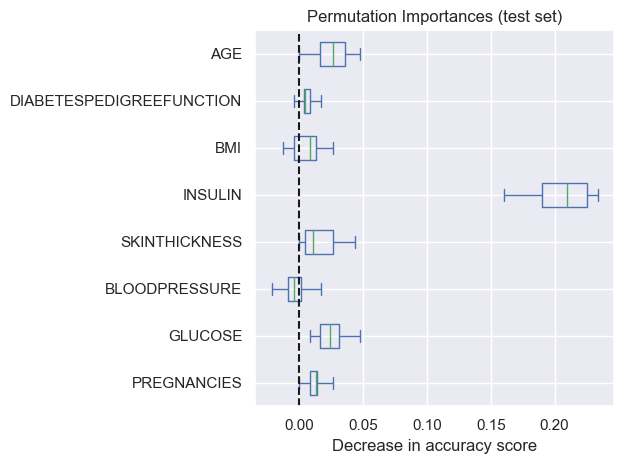

In [16]:
from sklearn.inspection import permutation_importance
feature_names = X_train.columns

# Compute permutation importance on the test split
result = permutation_importance(
    rf_model,
    X_test,
    y_test,
    n_repeats=20,
    random_state=78,
    n_jobs=-1,
)

importances = pd.DataFrame(result.importances.T, columns=feature_names)

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()

Index(['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE', 'INSULIN_copy'], dtype='str')


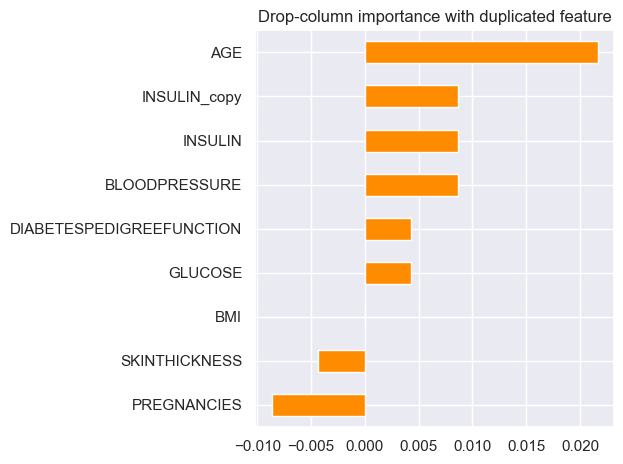

In [17]:
X_duplicate = X.copy()
X_duplicate["INSULIN_copy"] = X_duplicate["INSULIN"]

X_train, X_test, y_train, y_test = train_test_split(
    X_duplicate, y, test_size=0.30, random_state=41
)
print(X_train.columns)

drop_imp = drop_features(X_train.columns, X_train, y_train, X_test, y_test)
fig, ax = plt.subplots()
ax = drop_imp.plot.barh(color='darkorange', ax=ax)
ax.set_title("Drop-column importance with duplicated feature")
fig.tight_layout()
plt.show()

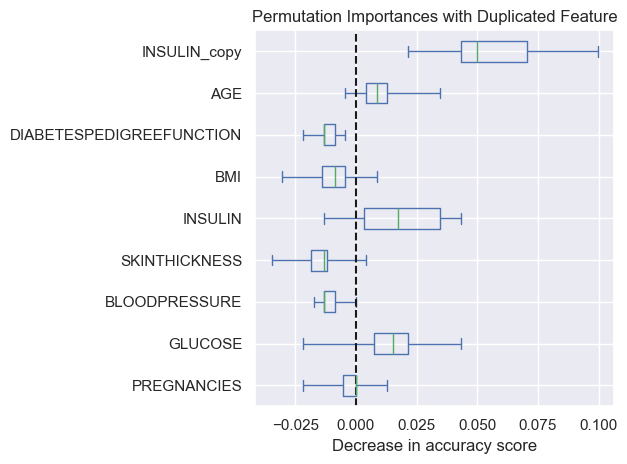

In [18]:
# Fit RF on duplicated-feature dataset and recompute permutation importance
rf_model_perm = RandomForestClassifier(random_state=41).fit(X_train, y_train)
result = permutation_importance(
    rf_model_perm,
    X_test,
    y_test,
    n_repeats=20,
    random_state=41,
    n_jobs=-1,
)

importances = pd.DataFrame(result.importances.T, columns=X_train.columns)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances with Duplicated Feature")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()

# Diabetes Risk Feature Importance

**Objective.** Explain model decisions and quantify feature contributions.

**Pipeline.** Model training followed by feature importance analysis.

**Evaluation.** Clinical interpretability of key drivers.


In [19]:
# Optional local dependency (install once in your environment if needed):
# !pip install lime
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.values.tolist(),
    verbose=True,
    mode='classification'
)

In [20]:
exp = explainer.explain_instance(X_test.values[90], rf_model_perm.predict_proba)
exp.as_list()

Intercept 0.23901878249008193
Prediction_local [0.78876011]
Right: 0.73


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[('GLUCOSE > 142.00', 0.22474838615913104),
 ('INSULIN_copy > 169.50', 0.10559768425103282),
 ('SKINTHICKNESS > 32.00', 0.09060807790307579),
 ('INSULIN > 169.50', 0.08759028496154324),
 ('DIABETESPEDIGREEFUNCTION > 0.62', 0.06154012044969459),
 ('24.00 < AGE <= 29.00', -0.01018331753472893),
 ('27.40 < BMI <= 32.00', -0.00472539400922594),
 ('72.00 < BLOODPRESSURE <= 80.00', -0.004248188366229321),
 ('1.00 < PREGNANCIES <= 3.00', -0.0011863307322638069)]